In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os
import pickle
from glob import glob
from itertools import product

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import RegularPolygon
from tqdm.notebook import tqdm

#from scipy.optimize import lsq_linear
#from sklearn.linear_model import LinearRegression

matplotlib.rcParams.update({'font.size': 18, 'figure.facecolor':'white', 'figure.figsize':(8, 8)})

%cd /home/naodell/work/hgcal/ECONAutoencoderStudy

/home/naodell/work/hgcal/ECONAutoencoderStudy


In [9]:
# get the data
input_file = open('data/output_0_0.pkl', 'rb')
data_dict = pickle.load(input_file)
df_tc = data_dict['tc']
df_gen = data_dict['gen']

In [10]:
# Draw some events overlaid in the first wedge
cmap = matplotlib.cm.get_cmap('Reds')

# get the data and apply some cuts
#cuts = 'tc_z > 0 and tc_x < 0. and tc_y < 0. and tc_subdet == 1 and tc_layer == 9'
cuts = 'tc_z < 0 and tc_subdet == 1 and tc_layer == 9 and tc_energy > 0.1'
df_tc['count'] = 1
df_cut = df_tc.query(cuts)
events = df_cut.index.get_level_values(0).unique()
event_ix = events[10]
event_tc = df_cut.loc[event_ix]
#event_gen = df_gen.loc[event_ix]

group_wafer = event_tc.groupby(['tc_waferu', 'tc_waferv'])
wafer_sums = group_wafer.sum()
energy_max = wafer_sums['tc_energy'].max()

# draw each module 
u = np.arange(-12, 11)
coord = np.array(list(product(u, u)))

# Horizontal cartesian coords
inner_radius = 0.82*32.8
outer_radius = 160
angle = np.pi/6
hex_radius = 0.95*8*2.54/2
d = 2*hex_radius*np.cos(angle)
#trans_matrix = np.array([[1., np.sin(angle)], [0., np.sin(np.pi/2 - angle)]])
xcoord = [d*(c[0] - c[1]*np.sin(angle)) for c in coord]
ycoord = [d*c[1]*np.sin(np.pi/2 - angle) for c in coord]


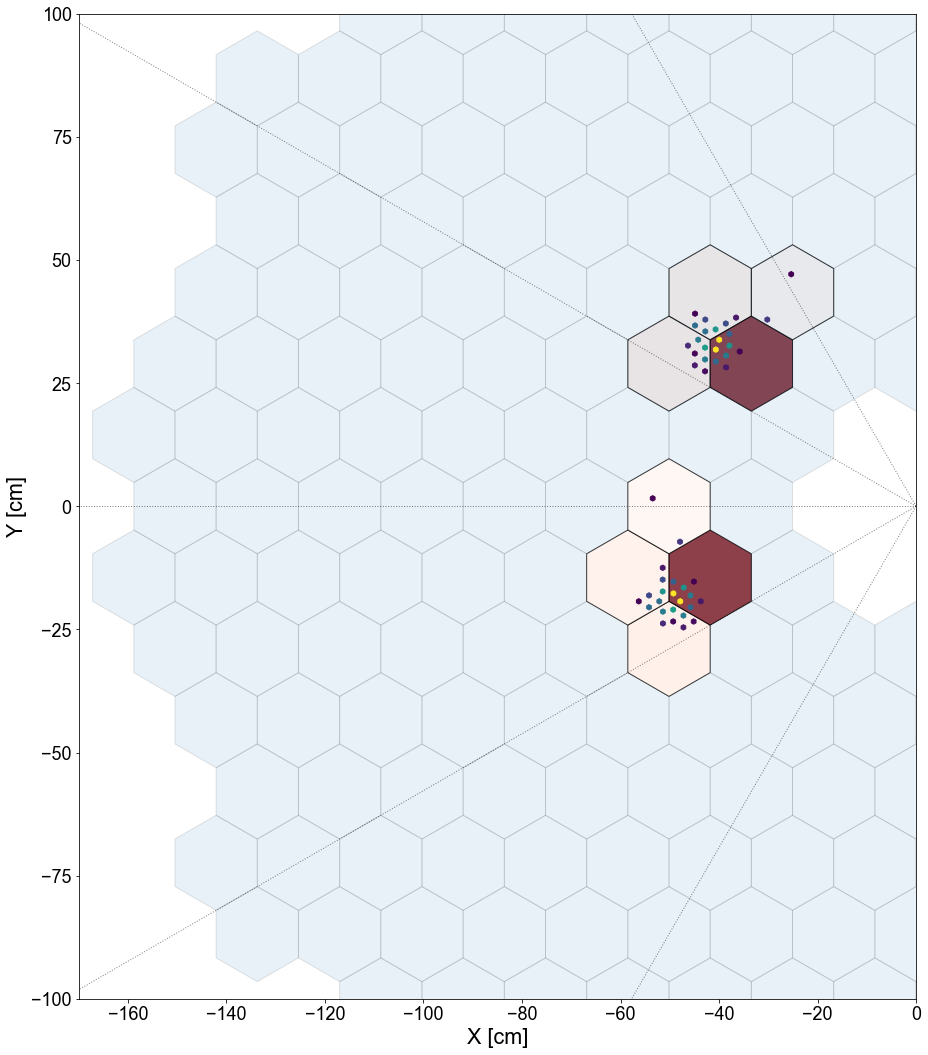

In [11]:
# plots demonstrating rotation of an event
fig, axes = plt.subplots(1, 1, figsize=(15, 15))

# rotate wafers and trigger cell coordinates
angle = -np.pi/3
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]) 

ax = axes
ax.set_aspect('equal')

# draw hexegonal grid
for x, y, u, v in zip(xcoord, ycoord, coord.T[0], coord.T[1]):
    
    # filter out wafers
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan(y/(x + 0.01)) 
    if (r < inner_radius or r > outer_radius):
        continue
        
    if (u, v) in wafer_sums.index:
        color = cmap(wafer_sums.loc[(u, v), 'tc_energy']/energy_max)
        alpha = 0.75
        
        x_rot, y_rot = np.dot(rotation_matrix, np.array([x, y]))
        poly = RegularPolygon((x_rot, y_rot), 
                             numVertices=6, 
                             radius=hex_radius, 
                             orientation=np.radians(0), 
                             facecolor=color, 
                             alpha=alpha, 
                             edgecolor='k',
                             zorder=1
                            )
        ax.add_patch(poly)
    else:
        color = 'C0'
        alpha = 0.1
        
    poly = RegularPolygon((x, y), 
                         numVertices=6, 
                         radius=hex_radius, 
                         orientation=np.radians(0), 
                         facecolor=color, 
                         alpha=alpha, 
                         edgecolor='k',
                         zorder=1
                        )
    ax.add_patch(poly)
    
    
    # Add text labels
    #if color == 'C0':
    #    ax.text(x, y+0.2, f'({u}, {v})', ha='center', va='center', size=10)
    
# draw lines every pi/3 radians
for angle in np.arange(0, 360, 30):
    rad = (angle/180)*np.pi
    ax.plot([0., 200*np.cos(rad)], [0., 200*np.sin(rad)], 'k:', linewidth=1, alpha=0.5)
    
#ax.add_patch(poly)
# overlay trigger cells.  Combine energy deposits from different events using groupby.
#wedge_condition = 'tc_waferu >= 2 and tc_waferu >= tc_waferv and tc_waferv >= 0'
#tc_sums = event_tc.query(wedge_condition).groupby(['tc_x', 'tc_y']).sum()
tc_sums = event_tc.groupby(['tc_x', 'tc_y']).sum()
tc_energy = tc_sums['tc_energy'].values
tc_x, tc_y = tc_sums.index.get_level_values(0).values, tc_sums.index.get_level_values(1).values
marker_size = 30. #/ (1 + np.exp(-tc_energy)/10)
scat = ax.scatter(tc_x, tc_y,
                  marker=(6, 0, 0), 
                  s=marker_size, 
                  c=tc_energy,
                  zorder=2,
                  norm=matplotlib.colors.LogNorm()
                 )

# carry out the rotation
X = np.array([tc_x, tc_y])
X_rotated = np.dot(rotation_matrix, X)

marker_size = 30. #/ (1 + np.exp(-tc_energy)/10)
scat = ax.scatter(X_rotated[0], X_rotated[1],
                  marker=(6, 0, 0), 
                  s=marker_size, 
                  c=tc_energy,
                  zorder=2,
                  norm=matplotlib.colors.LogNorm()
                 )
ax.set_xlim(-170, 0)
ax.set_ylim(-100, 100)
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')

#ax.set_ylabel('Y [cm]')
#cbar = fig.colorbar(scat, ax=ax, shrink=0.82)
#cbar.set_label('trigger cell energy [GeV]')

plt.tight_layout()
plt.show()